## CIFAR-10 CNN Image Classification - Data Augmentation
The problem of automatically classifying photographs of objects is difficult because of the near infinite number of permutations of objects, positions, lighting and so on. A standard computer vision and deep learning dataset for this problem was developed by the Canadian Institute for Advanced Research (CIFAR).

The CIFAR-10 dataset consists of 60,000 photos divided into 10 classes. Classes include common objects such as airplanes, automobiles, birds, cats and so on. The dataset is split in a standard way, where 50,000 images are used for training a model and the remaining 10,000 for evaluating its performance. The photos are in color with red, green and blue components, but are small measuring 32 by 32 pixel squares. 

State-of-the-art models have achieved 96% classification accuracy, with very good performance considered above 90% and human performance on the problem is at 94%. This is my attempt to use a relatively small amount of data samples along with data augmentation to achieve good results; hopefully.

In [1]:
# imports
import numpy as np
from keras.datasets import cifar10
from matplotlib import pyplot as plt
from PIL import Image as im
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

/home/brent/Dev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# set random seed
seed = 7
np.random.seed(seed)

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()  

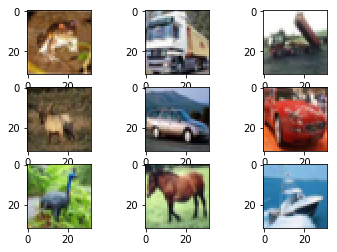

In [4]:
# check out images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(im.fromarray(X_train[i], 'RGB'))
plt.show()

## Data Augmented Model

In [5]:
# review input data
print("Input training shape:", X_train.shape)
print("Input test shape:", X_test.shape)
print("Output training shape:", y_train.shape)
print("Output test shape:", y_test.shape)

Input training shape: (50000, 32, 32, 3)
Input test shape: (10000, 32, 32, 3)
Output training shape: (50000, 1)
Output test shape: (10000, 1)


In [6]:
# one-hot encode the output vectors to convert them from a class number 
# to a binary matrix representation of a class number
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print("Number of output classes:", num_classes)

Number of output classes: 10


In [7]:
# validate OH encoding
print("Training output shape:", y_train.shape)
print("Test output shape:", y_test.shape)
print(y_test[3])

Training output shape: (50000, 10)
Test output shape: (10000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# define the CNN model
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), data_format="channels_last", activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))    
    return model    

In [9]:
# create the cnn model
model = cnn_model()
nb_epochs = 150
lrate = 0.01
decay = lrate / nb_epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [10]:
# normalize and augment the input training and validation data
batch_size = 20
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

training_datagen.fit(X_train)
X_test = X_test / 255

train_steps = len(X_train) / batch_size
val_steps = len(X_test) / batch_size

In [11]:
# fit the model
history = model.fit_generator(training_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=nb_epochs, steps_per_epoch=train_steps, validation_data=(X_test, y_test), validation_steps=val_steps).history

Epoch 1/150
2500/2500 [==============================] - 187s 75ms/step - loss: 1.9292 - acc: 0.2825 - val_loss: 1.6275 - val_acc: 0.4145
Epoch 2/150
2500/2500 [==============================] - 185s 74ms/step - loss: 1.5798 - acc: 0.4175 - val_loss: 1.3002 - val_acc: 0.5287
Epoch 3/150
2500/2500 [==============================] - 185s 74ms/step - loss: 1.3892 - acc: 0.4941 - val_loss: 1.1804 - val_acc: 0.5801
Epoch 4/150
2500/2500 [==============================] - 183s 73ms/step - loss: 1.2531 - acc: 0.5514 - val_loss: 0.9929 - val_acc: 0.6534
Epoch 5/150
2500/2500 [==============================] - 182s 73ms/step - loss: 1.1461 - acc: 0.5912 - val_loss: 0.9884 - val_acc: 0.6501
Epoch 6/150
2500/2500 [==============================] - 183s 73ms/step - loss: 1.0737 - acc: 0.6179 - val_loss: 0.9135 - val_acc: 0.6772
Epoch 7/150
2500/2500 [==============================] - 184s 73ms/step - loss: 1.0144 - acc: 0.6416 - val_loss: 0.8859 - val_acc: 0.6830
Epoch 8/150
2500/2500 [===========

Epoch 59/150
2500/2500 [==============================] - 176s 70ms/step - loss: 0.4203 - acc: 0.8537 - val_loss: 0.4355 - val_acc: 0.8573
Epoch 60/150
2500/2500 [==============================] - 177s 71ms/step - loss: 0.4184 - acc: 0.8541 - val_loss: 0.4326 - val_acc: 0.8572
Epoch 61/150
2500/2500 [==============================] - 177s 71ms/step - loss: 0.4152 - acc: 0.8538 - val_loss: 0.4481 - val_acc: 0.8508
Epoch 62/150
2500/2500 [==============================] - 177s 71ms/step - loss: 0.4127 - acc: 0.8566 - val_loss: 0.4255 - val_acc: 0.8611
Epoch 63/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.4100 - acc: 0.8562 - val_loss: 0.4366 - val_acc: 0.8562
Epoch 64/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.4077 - acc: 0.8572 - val_loss: 0.4238 - val_acc: 0.8591
Epoch 65/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.4010 - acc: 0.8601 - val_loss: 0.4157 - val_acc: 0.8655
Epoch 66/150
2500/2500 [===

Epoch 118/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3206 - acc: 0.8874 - val_loss: 0.3774 - val_acc: 0.8771
Epoch 119/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3163 - acc: 0.8881 - val_loss: 0.3945 - val_acc: 0.8739
Epoch 120/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3169 - acc: 0.8878 - val_loss: 0.3740 - val_acc: 0.8789
Epoch 121/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3141 - acc: 0.8890 - val_loss: 0.3883 - val_acc: 0.8750
Epoch 122/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3139 - acc: 0.8899 - val_loss: 0.3953 - val_acc: 0.8727
Epoch 123/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3080 - acc: 0.8927 - val_loss: 0.3868 - val_acc: 0.8755
Epoch 124/150
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3126 - acc: 0.8893 - val_loss: 0.3808 - val_acc: 0.8737
Epoch 125/150
2500/2

In [12]:
# evaluate model
score = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (score[1]*100))

10000/10000 [==============================] - 9s 915us/step
Accuracy: 87.77%


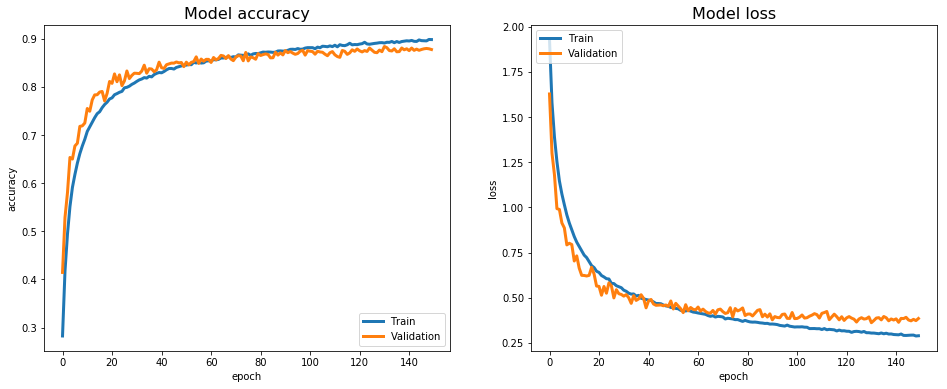

In [13]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history['acc'], label='Train', linewidth=3)
axis1.plot(history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history['loss'], label='Train', linewidth=3)
axis2.plot(history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper left')
plt.show()